In [1]:
# Support for math
import numpy as np
import math

# Plotting tools
from matplotlib import pyplot as plt
import matplotlib

import warnings
warnings.filterwarnings('ignore')

#File Tools for local
import pandas as pd

#Sampling
from pyDOE import lhs

In [2]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import qExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.models.deterministic import PosteriorMeanModel
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition.utils import get_infeasible_cost
from botorch.acquisition.objective import PosteriorTransform
from botorch.acquisition.analytic import UpperConfidenceBound
from botorch.acquisition import AcquisitionFunction
from botorch.acquisition.analytic import LogProbabilityOfImprovement
from botorch.acquisition.analytic import ProbabilityOfImprovement
from botorch.acquisition.analytic import PosteriorMean
from botorch.acquisition import qUpperConfidenceBound
from botorch.acquisition.active_learning import qNegIntegratedPosteriorVariance
from botorch.acquisition.active_learning import PairwiseMCPosteriorVariance

## Mixed
from gpytorch.constraints import Interval
from botorch.models import MixedSingleTaskGP
# botorch.optim.optimize.optimize_acqf_mixed
from botorch.optim import optimize_acqf_mixed


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
dtype = torch.float32

cpu


# Output

['102119 (1).csv', '102119 (2).csv', '102119 (3).csv', '102119 (4).csv', '102119 (5).csv', '102119 (6).csv', '102119 (7).csv', '102119 (8).csv', '102119 (9).csv', '102119 (10).csv', '102119 (11).csv', '102119 (12).csv', '102119 (13).csv', '102119 (14).csv', '102119 (15).csv', '102119 (16).csv', '102119 (17).csv', '102119 (18).csv', '102119 (19).csv', '102119 (20).csv', '102119 (21).csv', '102119 (22).csv', '102119 (23).csv', '102119 (24).csv', '102119 (25).csv', '102119 (26).csv', '102119 (27).csv', '102119 (28).csv', '102119 (29).csv', '102119 (30).csv', '102119 (31).csv', '102119 (32).csv', '102119 (33).csv', '102119 (34).csv', '102119 (35).csv', '102119 (36).csv', '102119 (37).csv', '102119 (38).csv', '102119 (39).csv', '102119 (40).csv', '102119 (41).csv', '102119 (42).csv', '102119 (43).csv', '102119 (44).csv', '102119 (45).csv', '102119 (46).csv', '102119 (47).csv', '102119 (48).csv']


Deconvolving mixture: 100%|██████████| 1/1 [00:00<00:00, 98.46it/s]


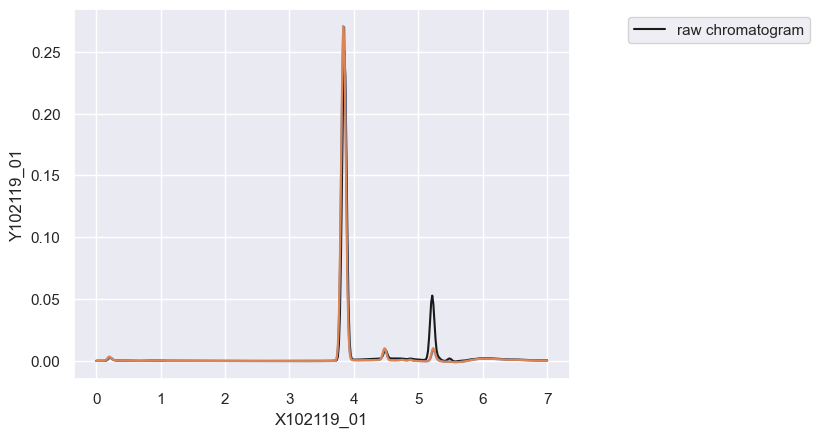

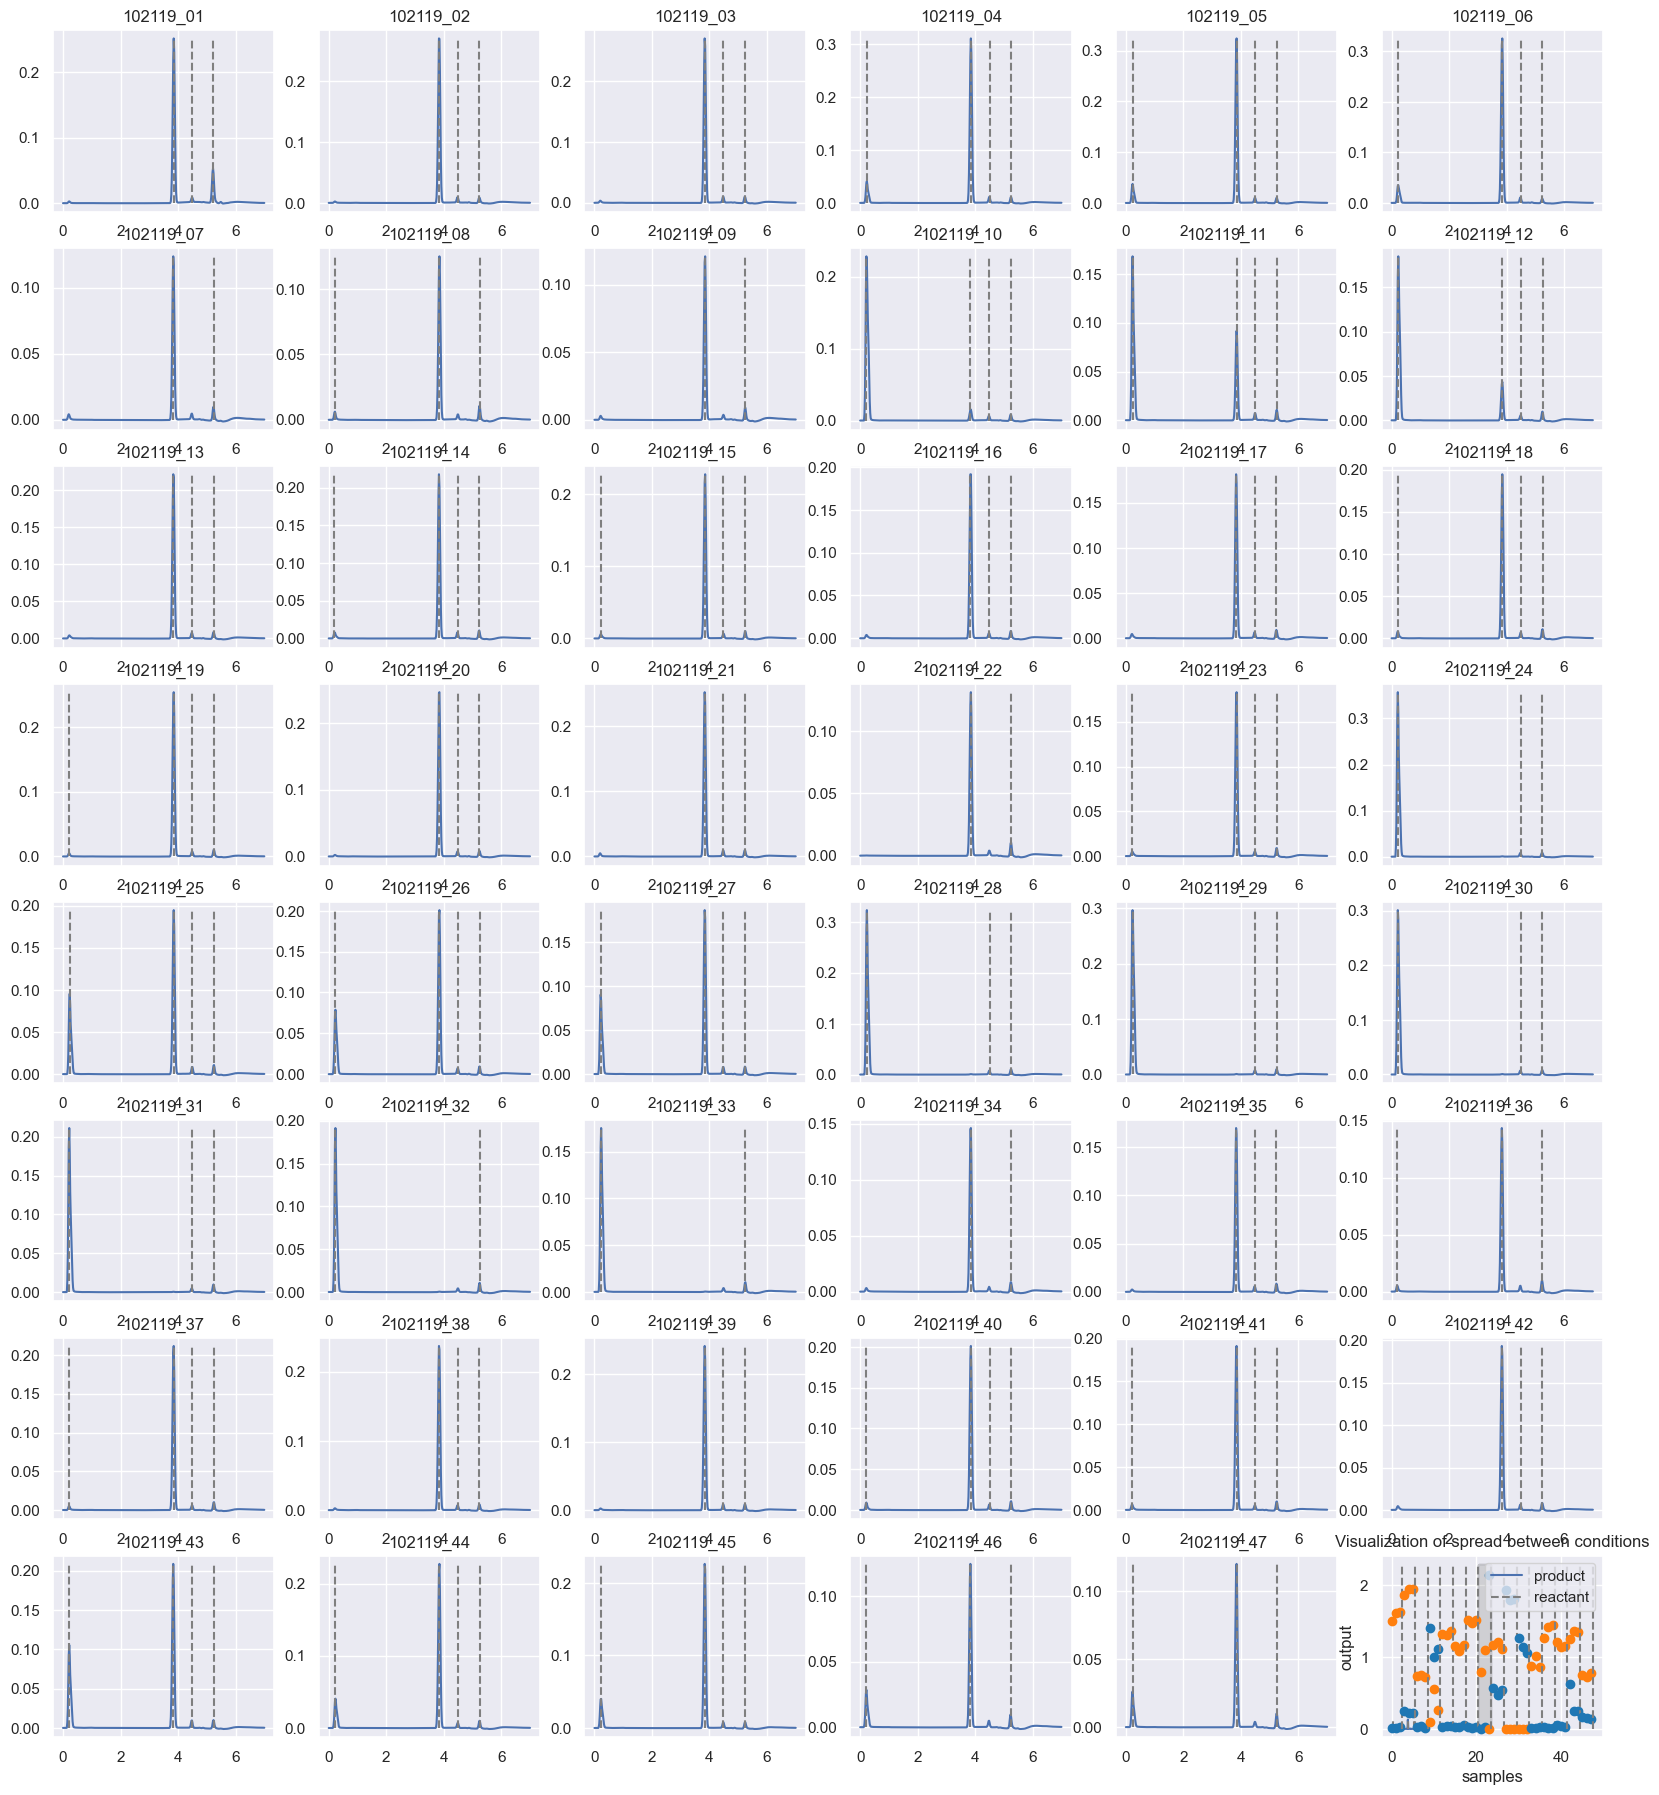

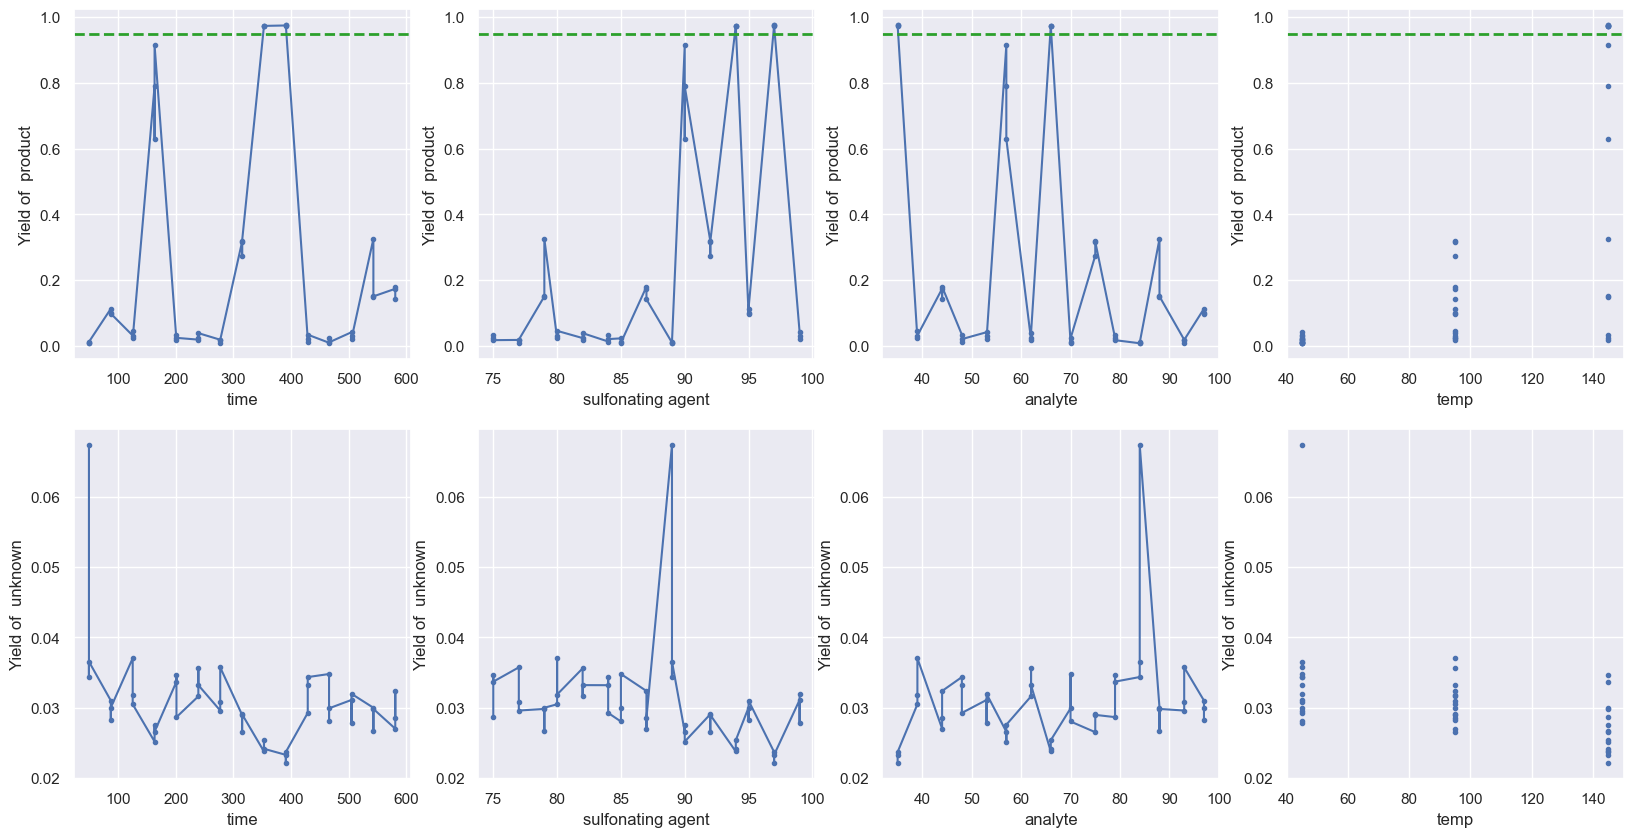

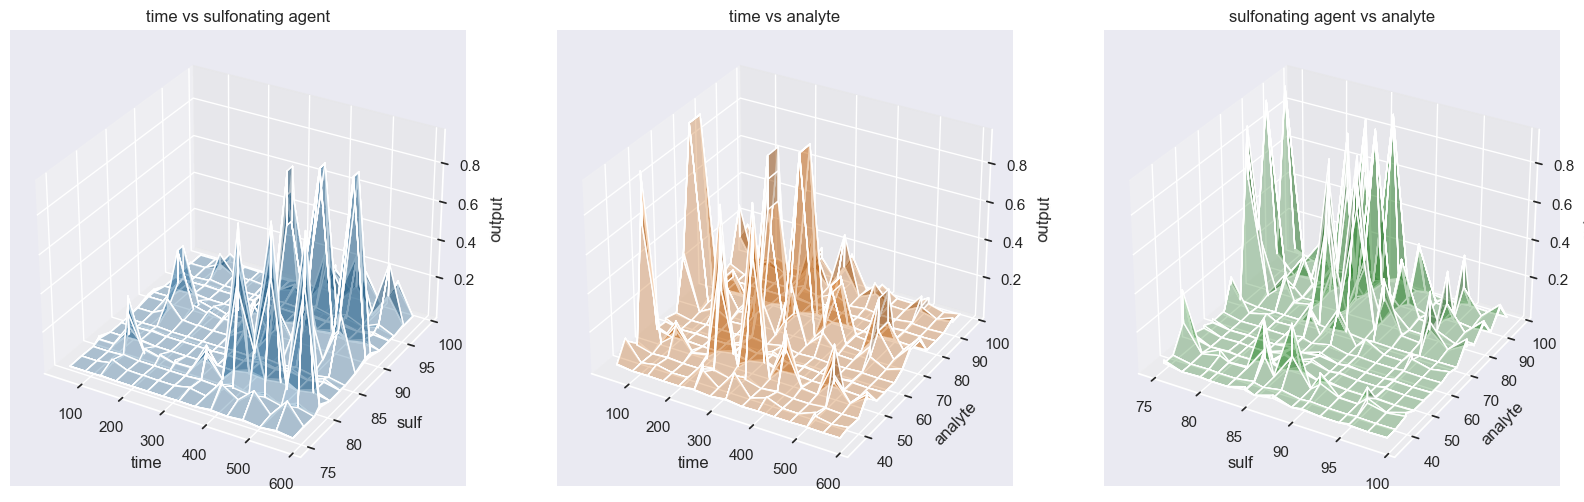

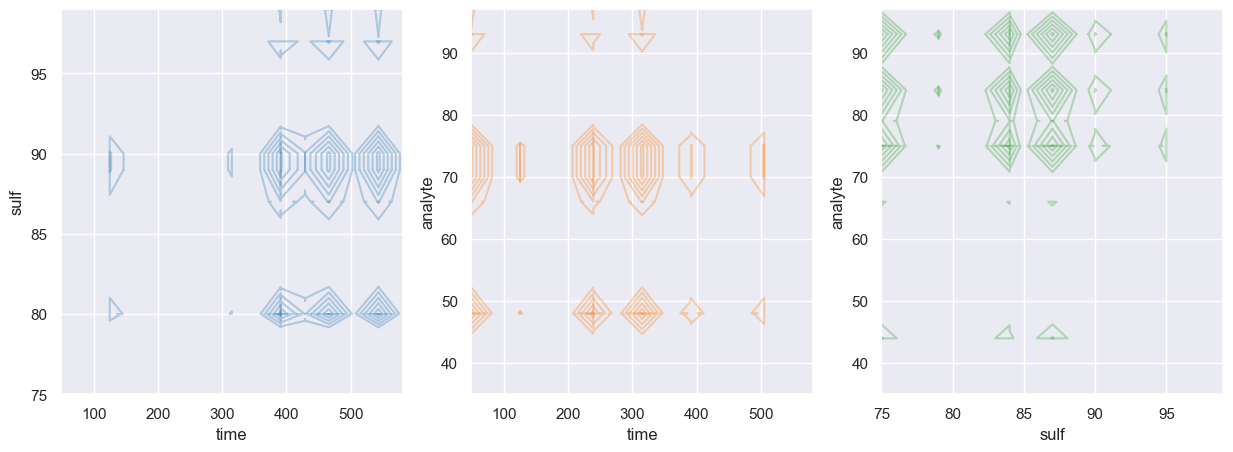

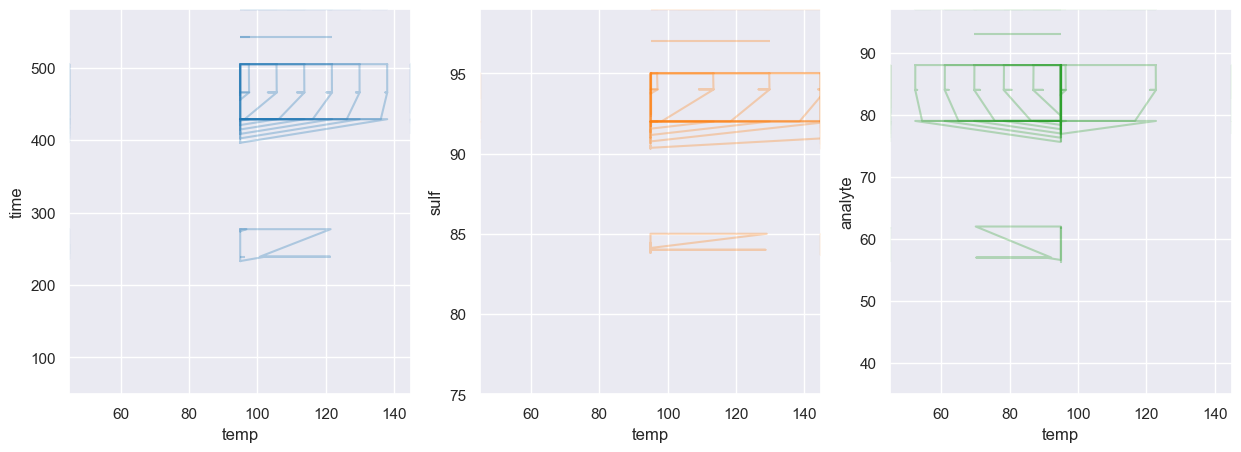

In [4]:
from PNNL_spectra_extract import data_102119
#data_102119.head(16)[['time','temp','analyte','yield product']]
# /Users/clarat/Documents/Sun_Lab/PNNL/PNNL_spectra_extract
# %run /Users/clarat/Documents/Sun_Lab/PNNL/PNNL_spectra_extract

In [5]:
avg_data = data_102119.groupby('time').mean().reset_index()[['time','temp','sulf','analyte','yield product']]
avg_data

,time,temp,sulf,analyte,yield product
0,49,45.0,89.0,84.0,0.009903
1,87,95.0,95.0,97.0,0.103900
2,125,95.0,80.0,39.0,0.033182
3,163,145.0,90.0,57.0,0.777693
4,201,145.0,75.0,79.0,0.025126
5,239,95.0,82.0,62.0,0.027045
6,277,45.0,77.0,93.0,0.015058
7,315,95.0,92.0,75.0,0.303520
8,353,145.0,94.0,66.0,0.972973
9,391,145.0,97.0,35.0,0.974877


In [6]:
std_data = data_102119.groupby('time').std().reset_index()[['time','temp','sulf','analyte','yield product']]
std_data

,time,temp,sulf,analyte,yield product
0,49,0.0,0.0,0.0,0.002110
1,87,0.0,0.0,0.0,0.007884
2,125,0.0,0.0,0.0,0.011663
3,163,0.0,0.0,0.0,0.142828
4,201,0.0,0.0,0.0,0.008250
5,239,0.0,0.0,0.0,0.010353
6,277,0.0,0.0,0.0,0.005608
7,315,0.0,0.0,0.0,0.025185
8,353,0.0,0.0,0.0,0.001016
9,391,0.0,0.0,0.0,0.000763


# Split the data

In [7]:
x1 = torch.tensor([avg_data['time'],avg_data['temp'],avg_data['sulf'],avg_data['analyte']],dtype=torch.float32).T#[:48]
y1 = torch.tensor(avg_data['yield product'],dtype=torch.float32).reshape(-1,1)

# 4D BO to determine temps

In [8]:
#bounds = torch.tensor([[30., 20., 75. , 33.], [600., 170., 100.,100.]], dtype=dtype, device=device)
bounds = torch.tensor([[avg_data['time'].min(),avg_data['temp'].min(),avg_data['sulf'].min() , avg_data['analyte'].min()], [avg_data['time'].max(), avg_data['temp'].max(), avg_data['sulf'].max() , avg_data['analyte'].max()]], dtype=dtype, device=device)
#bounds = torch.tensor([[0,70,100], [80,105,150]], dtype=dtype, device=device)
#bounds = torch.tensor([[0], [150]], dtype=dtype, device=device)
#[75.0, 100.0], [33.0, 100.0],[20.0,170.0],[30.0,600.0]
batch_size = 3 #train_size

# For EI 
best_f = torch.tensor(1 ,dtype=dtype) 
target_vector = torch.tensor([1],dtype=dtype) # target is 95% or highers


In [9]:
train_x = torch.tensor(x1, dtype=dtype).to(device=device, dtype=dtype)
train_y = torch.tensor(y1, dtype=dtype)
#train_x,train_y

In [10]:
gp_model = SingleTaskGP(train_x, train_y).to(device=device, dtype=dtype)
mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
fit_gpytorch_model(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

In [11]:
acq_funcs = qNegIntegratedPosteriorVariance(model=gp_model, mc_points= train_x)

candidate2, _ = optimize_acqf(
    acq_function=acq_funcs,
    bounds=bounds,
    q=batch_size,
    num_restarts=1,
    raw_samples=100,
    options={"dtype": dtype, "device": device}
)

print("Centroids of Temperature Clusters:")
print(candidate2.round())
centroids = candidate2[:,1]

Centroids of Temperature Clusters:
tensor([[517.,  66.,  86.,  43.],
        [180., 120.,  77.,  38.],
        [540.,  89.,  79.,  42.]])


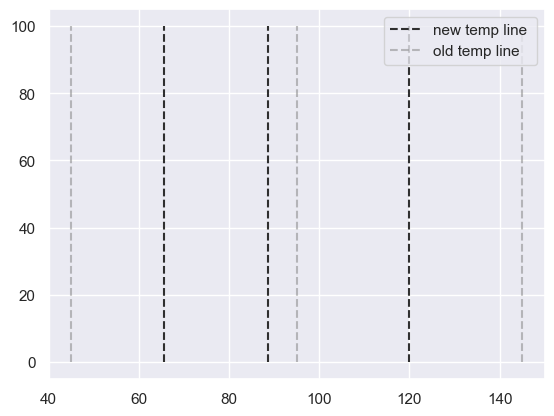

In [12]:
old = [45,95,145]
plt.vlines(centroids,0,100, color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,0,100, color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.legend(['new temp line ','old temp line'])

# BO 4D + clustered temps

In [13]:
# BO parameters
batch_size = 15

# Define the bounds for continuous variables
bounds = torch.tensor([
    [30.0, 20.0, 75.0, 33.0],  # Lower bounds for the 3 continuous variables
    [600.0, 170.0,100.0, 100.0]   # Upper bounds for the 3 continuous variables
])
# xlimits = np.array([[75.0, 100.0], [33.0, 100.0],[20.0,170.0],[30.0,600.0]])

# Discrete variable choices from 1D BO
discrete_choices= centroids.numpy().T
fixed_features_list = [{1: float(discrete_choices[0])},{1: float(discrete_choices[1])},{1: float(discrete_choices[2])}]#[{0: float(choice)} for choice in discrete_choices]
fixed_features_list

[{1: 65.50511932373047}, {1: 119.85845184326172}, {1: 88.72348022460938}]

In [14]:
from botorch.models import MixedSingleTaskGP
train_X = torch.tensor(x1, dtype=dtype).to(device=device, dtype=dtype)
train_Y = torch.tensor(y1, dtype=dtype)

model = MixedSingleTaskGP(train_X, train_Y, cat_dims=[1])
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_model(mll)


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-05)
    )
  )
  (model): MixedSingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-05)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): AdditiveKernel(
      (kernels): ModuleList(
        (0): ScaleKernel(
          (base_kernel): AdditiveKernel(
            (kernels): ModuleList(
              (0): MaternKernel(
                (raw_lengthscale_constraint): GreaterThan(1.000E-04)
              )
              (1): ScaleKernel(
                (base_kernel): CategoricalKernel(
                  (raw_lengthscale_constraint): GreaterThan(1.000E-06)
                )
                (raw_outputscale_constraint): Positive()
              )
            )
         

In [15]:
# Set of aquisition functions that can be used for mixed
qEI = qExpectedImprovement(model=model, best_f=best_f)
qUCB = qUpperConfidenceBound(model=model, beta=5) #sampler=SobolQMCNormalSampler(num_samples=15) beta = 0.1
qPV = qNegIntegratedPosteriorVariance(model=model, mc_points = x1) # This does not work for mixed... 

In [16]:
acq_funcs = qPV

candidate1, _ = optimize_acqf(
    acq_function=acq_funcs,
    bounds=bounds,
    q=batch_size,
    num_restarts=10,
    raw_samples=100,
    options={"dtype": dtype, "device": device}
    
)

# # Choose aquisition functions
# acq_funcs = qEI

# # Re-run the BO for the mixed with constrained temps
# candidate1, _ = optimize_acqf_mixed(
#     acq_function=acq_funcs,
#     bounds=bounds,
#     q=batch_size,
#     fixed_features_list=fixed_features_list,
#     num_restarts=10,
#     raw_samples=15,
#     options={"dtype": dtype, "device": device}
# )

In [17]:
time = candidate1[:,0]//1
temp = candidate1[:,1]//1
sulf = candidate1[:,2]//1
anly = candidate1[:,3]//1

data = {
    'time': time,
    'temp': temp,
    'sulf': sulf,
    'anly': anly
}
df_candidate1 = pd.DataFrame(data)
df_candidate1

,time,temp,sulf,anly
0,317.0,167.0,83.0,55.0
1,421.0,85.0,86.0,75.0
2,179.0,143.0,76.0,38.0
3,148.0,147.0,99.0,41.0
4,217.0,105.0,85.0,60.0
5,489.0,147.0,86.0,51.0
6,114.0,82.0,92.0,45.0
7,173.0,65.0,78.0,67.0
8,512.0,169.0,93.0,51.0
9,199.0,74.0,82.0,74.0


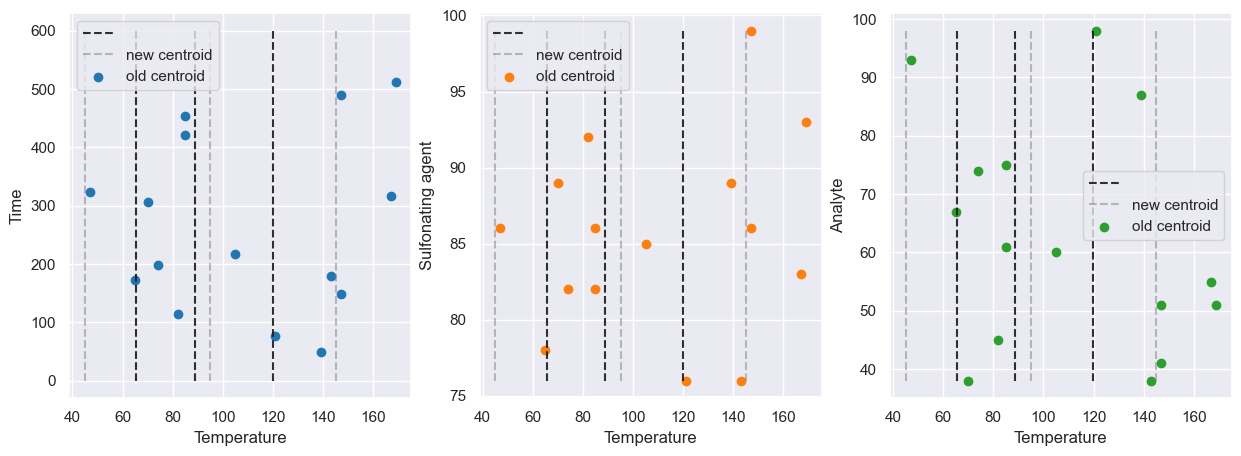

In [18]:
old = [45,95,145]

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.vlines(centroids,0,600, color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,0,600, color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.scatter(df_candidate1['temp'],df_candidate1['time'],color = 'tab:blue')
plt.xlabel('Temperature')
plt.ylabel('Time')
plt.legend(['','new centroid','old centroid'])

plt.subplot(1,3,2)
plt.vlines(centroids,df_candidate1['sulf'].min(),df_candidate1['sulf'].max(), color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,df_candidate1['sulf'].min(),df_candidate1['sulf'].max(), color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.scatter(df_candidate1['temp'],df_candidate1['sulf'],color = 'tab:orange')
plt.xlabel('Temperature')
plt.ylabel('Sulfonating agent')
plt.legend(['','new centroid','old centroid'])

plt.subplot(1,3,3)
plt.vlines(centroids,df_candidate1['anly'].min(),df_candidate1['anly'].max(), color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,df_candidate1['anly'].min(),df_candidate1['anly'].max(), color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.scatter(df_candidate1['temp'],df_candidate1['anly'],color = 'tab:green')
plt.xlabel('Temperature')
plt.ylabel('Analyte')
plt.legend(['','new centroid','old centroid'])



# Projection ? (Cluster?)

In [20]:
temp4D = []

for i in range(candidate1.shape[0]):
    id = abs(candidate1[i,1]-centroids).argmin()
    temp4D.append(centroids[id])
temp4D =np.array(temp4D).T

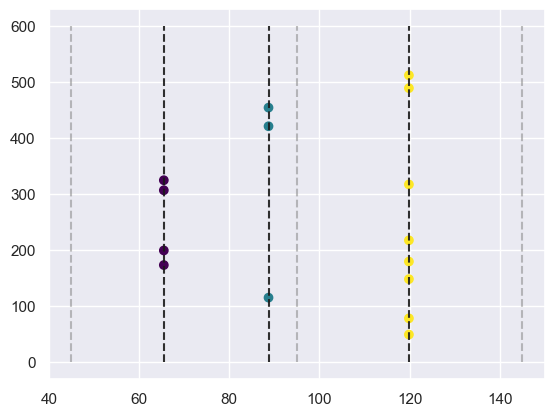

In [23]:
old = [45,95,145]
plt.vlines(centroids,0,600, color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,0,600, color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.scatter(temp4D,candidate1[:,0],c=temp4D, cmap='viridis')

In [24]:
def contour_all(ax,data_temp,input1,input2,output,color):
    # Grab some test data.
    # X, Y, Z = axes3d.get_test_data(0.05)
    X = data_temp.sort_values(input1)[input1].to_numpy()
    Y = data_temp.sort_values(input2)[input2].to_numpy()
    X, Y = np.meshgrid(X, Y) 
    out1,out2 = data_temp.sort_values(input1)[output].to_numpy(),data_temp.sort_values(input2)[output].to_numpy() #data_temp[output].to_numpy(),data_temp[output].to_numpy()#
    Z = np.matmul(out1.reshape(len(out1),1),out2.reshape(1,len(out2)))
    #Z1,Z2 = np.meshgrid(data_temp.sort_values(input1)[output].to_numpy(), data_temp.sort_values(input2)[output].to_numpy())

    ## Plot outside 
    # fig = plt.figure()
    # ax = fig.add_subplot(projection='3d')
    ## Plot a basic wireframe.
    #ax.plot_wireframe(X, Y, Z1, rstride=10, cstride=0,color='tab:grey')
    ax.contour(X, Y, Z,8,alpha= 0.3,colors=color)
    #ax.contourf(X, Y, Z, 8, alpha=.5) # plt.contourf(X, Y, f(X, Y), 8, alpha=.75, cmap=plt.cm.hot)
    #C = ax.contour(X, Y, Z, 8, colors='black', linewidth=.25,linstlyle = '--') # C = plt.contour(X, Y, f(X,Y), 8, colors='black', linewidth=.5)
    #ax.clabel(C, inline=1, fontsize=1)


    #ax.view_init(elev=20, azim=120) 
    ax.set_xlabel(input1)
    ax.set_ylabel(input2)

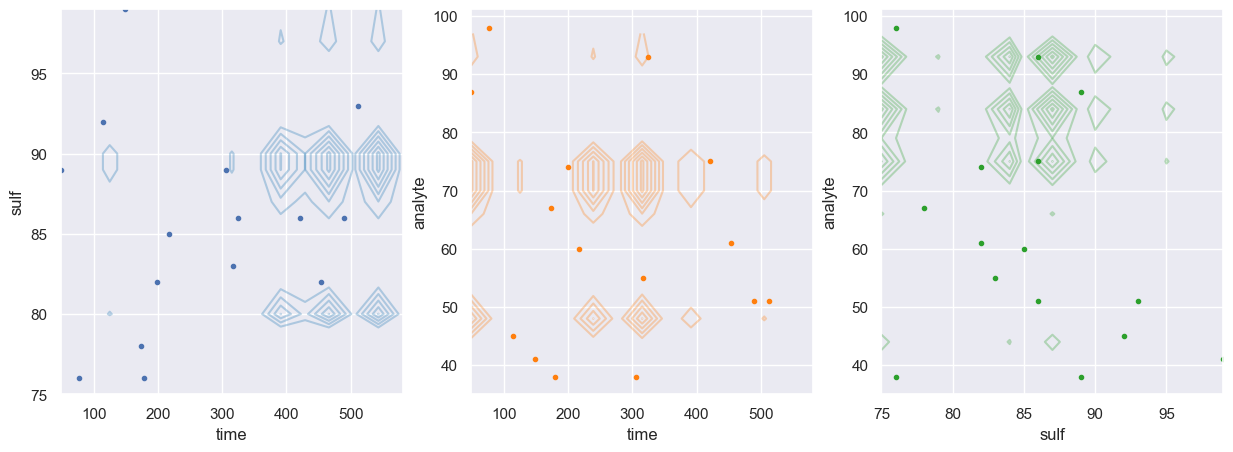

In [25]:
fig,(ax,ax1,ax2) = plt.subplots(1, 3, figsize=(15, 5))

contour_all(ax,avg_data,'time','sulf','yield product','tab:blue')
ax.scatter(df_candidate1['time'],df_candidate1['sulf'],marker='.')

contour_all(ax1,avg_data,'time','analyte','yield product','tab:orange')
ax1.scatter(df_candidate1['time'],df_candidate1['anly'],marker='.',color='tab:orange')

contour_all(ax2,avg_data,'sulf','analyte','yield product','tab:green')
ax2.scatter(df_candidate1['sulf'],df_candidate1['anly'],marker='.',color='tab:green')